# Text Classification with SVM
Source: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

I want to compare SVM with other Machine Learning and DNN methods.

## SVM

In [19]:
import re
import pandas as pd
import joblib
from pandas.core.series import Series
from time import time
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', download_dir='data/nltk_data')
nltk.download('punkt', download_dir='data/nltk_data')
nltk.download('wordnet', download_dir='data/nltk_data')

nltk.data.path.append('data/nltk_data')

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to data/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to data/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_test = pd.read_csv('../data/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')
df_train = pd.read_csv('../data/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
df_test.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [3]:
# Drop unrelevent features
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]

df_test.drop(unrelevant_features,inplace=True,axis=1)
df_train.drop(unrelevant_features,inplace=True,axis=1)
df_test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [4]:
df_test['Sentiment'].value_counts()

# Convert Sentiment to numerical values
df_test['Sentiment_numerical'] = df_test['Sentiment'].map({
    'Extremely Negative':0, 
    'Negative':0, 
    'Neutral':1, 
    'Positive':2, 
    'Extremely Positive':2
})

df_train['Sentiment_numerical'] = df_train['Sentiment'].map({
    'Extremely Negative':0, 
    'Negative':0, 
    'Neutral':1, 
    'Positive':2, 
    'Extremely Positive':2
})

df_test.head(5)

,OriginalTweet,Sentiment,Sentiment_numerical
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,0
1,When I couldn't find hand sanitizer at Fred Me...,Positive,2
2,Find out how you can protect yourself and love...,Extremely Positive,2
3,#Panic buying hits #NewYork City as anxious sh...,Negative,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,1


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Negative'),
  Text(1, 0, 'Positive'),
  Text(2, 0, 'Neutral'),
  Text(3, 0, 'Extremely Positive'),
  Text(4, 0, 'Extremely Negative')])

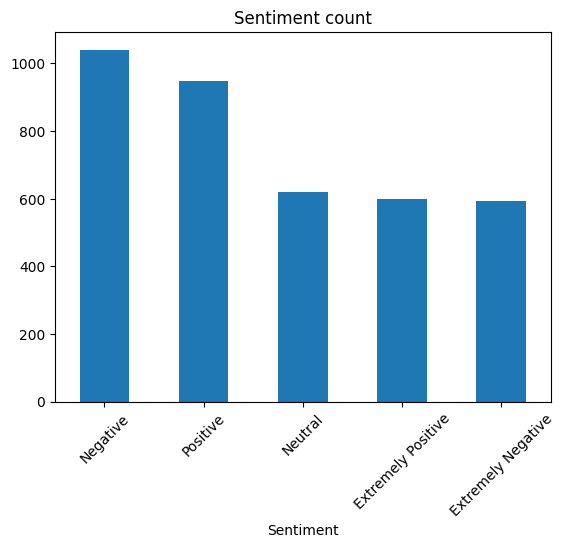

In [6]:
# Bar plot of the Sentiment
import matplotlib.pyplot as plt
sentiment_count = df_test['Sentiment'].value_counts()
sentiment_count.plot(kind='bar')
plt.title('Sentiment count')
plt.xticks(rotation=45)

In [11]:
# Preprocess
lemma = WordNetLemmatizer()
def preprocess(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    
    # Lower text
    text = text.lower()

 
    # Tokenizing and lemmatizing
    text = word_tokenize(text)
    text = [lemma.lemmatize(word) for word in text]
    
    # Remove stopwords
    stop_words = stopwords.words("english")
    
    text = [word for word in text if word not in stop_words]
   
    # Joining
    text = ' '.join(text)
    
    return text

df_test['CleanedText'] = df_test.OriginalTweet.apply(preprocess) # apply to each string
df_train['CleanedText'] = df_train.OriginalTweet.apply(preprocess) # apply to each string

In [12]:
df_train.head() 

,OriginalTweet,Sentiment,Sentiment_numerical,CleanedText
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,menyrbie philgahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,2,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,2,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,Positive,2,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,ready go supermarket covid outbreak im paranoi...


In [13]:
# Create bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000)
BOW_train = vectorizer.fit_transform(df_train.CleanedText).toarray()
BOW_test = vectorizer.transform(df_test.CleanedText).toarray()


In [14]:
# Split
print(BOW_train.shape)
print(BOW_test.shape)

(41157, 5000)
(3798, 5000)


In [86]:
start_time = time()
model = SVC(kernel='rbf')
model.fit(BOW_train, df_train.Sentiment_numerical)
end_time = time()
print(f"Training time: {end_time-start_time}")

In [84]:
# Prediction and evaluation
# Save the SVC model
import joblib
joblib.dump(model, '../out/textclass_rbf_svc.pkl')

pred = model.predict(BOW_test)
acc = accuracy_score(pred, df_test.Sentiment_numerical)
print("Train accuracy: ", acc)

Train accuracy:  0.794102159031069


In [ ]:
# Perform Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Set up the grid search

In [21]:
# Load the model
model = joblib.load('../out/textclass_lin_svc.pkl')

# Perform prediction
pred = model.predict(BOW_test)
acc = accuracy_score(pred, df_test.Sentiment_numerical)
print("Test accuracy: ", acc)

# Classification report
print(classification_report(df_test.Sentiment_numerical, pred))

Test accuracy:  0.794102159031069
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1633
           1       0.70      0.71      0.71       619
           2       0.81      0.83      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.78      0.78      0.78      3798
weighted avg       0.79      0.79      0.79      3798



Text(0.5, 1.0, 'Confusion Matrix for SVC Linear')

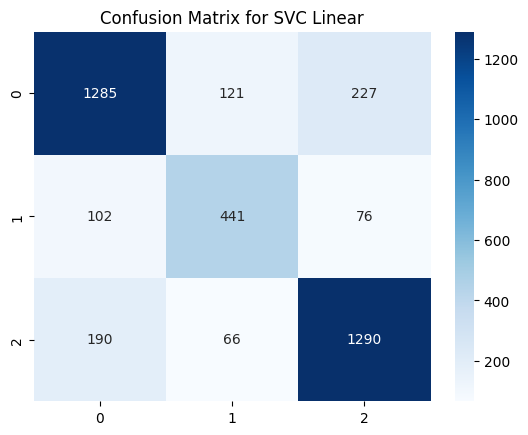

In [31]:
# Confusion matrix
cm = confusion_matrix(df_test.Sentiment_numerical, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVC Linear')

## Logistic Regression
Let's see how good logistic regression is at classifying text.

In [15]:
# Logistic Regression to classify the data
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Create the model
linear_regression = nn.Linear(5000, 3)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_regression.parameters(), lr=0.01)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(BOW_train, df_train.Sentiment_numerical, test_size=0.2, random_state=42)
X_test, y_test = BOW_test, df_test.Sentiment_numerical

# Convert to tensor
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [24]:
# Train the model
epochs = 100
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train.values).long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

history = {"train_acc": [], "train_loss": [], "val_loss": [], "val_acc": []}
start_time = time()
for epoch in range(epochs):
    acc, loss_ = 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = linear_regression(X_batch)
        acc += (y_pred.argmax(1) == y_batch).float().mean()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}, Acc: {acc / len(train_loader)}")
        
    avg_acc = acc / len(train_loader)
    history["train_acc"].append(avg_acc)
end_time = time()
print(f"Training time: {end_time-start_time}")

Epoch: 0, Loss: 5.236230373382568, Acc: 0.8443610072135925
Epoch: 10, Loss: 2.3022923469543457, Acc: 0.8407149314880371
Epoch: 20, Loss: 1.9450938701629639, Acc: 0.8401750922203064
Epoch: 30, Loss: 7.157704830169678, Acc: 0.8414305448532104
Epoch: 40, Loss: 1.9326884746551514, Acc: 0.8414797186851501
Epoch: 50, Loss: 7.62880277633667, Acc: 0.8409870266914368
Epoch: 60, Loss: 9.390359878540039, Acc: 0.8428565263748169
Epoch: 70, Loss: 2.7779219150543213, Acc: 0.8429601192474365
Epoch: 80, Loss: 2.691084384918213, Acc: 0.841698408126831
Epoch: 90, Loss: 1.9834293127059937, Acc: 0.8414619565010071
Training time: 57.092649936676025


Test accuracy:  tensor(0.7280)


Text(0.5, 1.0, 'Confusion matrix for Logistic Regression')

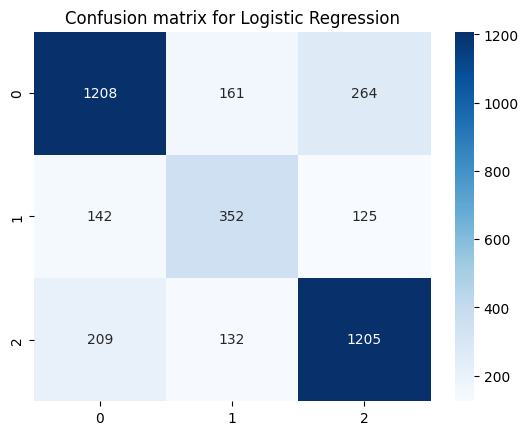

In [32]:
# Evaluate the model
y_pred = linear_regression(torch.tensor(X_test).float())

# Calculate the accuracy
test_acc = (y_pred.argmax(1) == torch.tensor(y_test.values).long()).float().mean()
print("Test accuracy: ", test_acc)

# Save the model
torch.save(linear_regression, '../out/textclass_logistic_regression.pth')

# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred.argmax(1).numpy())
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix for Logistic Regression')


## Deep Neural Network
What if we use a slightly more complex deep neural network

In [30]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(5000, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)
    
# Create the model
dnn = DNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(dnn.parameters(), lr=0.01)

# Train the model
epochs = 100
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train.values).long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(train_dataset.tensors[0].shape)
print(train_dataset.tensors[1].shape, train_dataset.tensors[1].unique())

torch.Size([32925, 5000])
torch.Size([32925]) tensor([0, 1, 2])


In [ ]:
history = {"train_acc": [], "train_loss": [], "val_loss": [], "val_acc": []}
start_time = time()
for epoch in range(epochs):
    acc, loss_ = 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = dnn(X_batch)
        acc += (y_pred.argmax(1) == y_batch).float().mean()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}, Acc: {acc / len(train_loader)}")
        
    avg_acc = acc / len(train_loader)
    history["train_acc"].append(avg_acc)


Ok. So a MLP clearly does not work.

## LSTM
Let's try a simple recurrent neural network with LSTM cells.

In [58]:
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(5000, 128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(128*2, 64, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(64*2, 3)
        self.softmax = nn.Softmax(dim=1)
    
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.lstm2(x)
        x = self.linear(x[:, -1, :])
        return self.softmax(x)
    
# Create the model
simple_lstm = SimpleLSTM()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_lstm.parameters(), lr=0.01)

# Visualize the model using torchsummary
from torchsummary import summary
# summary(simple_lstm, (1, 5000))

In [59]:
# Train the model
epochs = 100
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train.values).long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test.values).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# M1 chip device using mps
device = "cpu"
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
print(device)
    
history = {"train_acc": [], "train_loss": [], "val_loss": [], "val_acc": []}
start_time = time()
for epoch in range(epochs):
    acc, loss_ = 0, 0
    val_acc, val_loss_ = 0, 0
    simple_lstm.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = simple_lstm(X_batch.unsqueeze(1))
        acc += (y_pred.argmax(1) == y_batch).float().mean()
        loss = loss_fn(y_pred, y_batch)
        loss_ += loss.item()
        loss.backward()
        optimizer.step()
    
    simple_lstm.eval()
    for X_batch, y_batch in test_loader:
        y_pred = simple_lstm(X_batch.unsqueeze(1))
        val_acc += (y_pred.argmax(1) == y_batch).float().mean()
        val_loss = loss_fn(y_pred, y_batch)
        val_loss_ += val_loss.item()
        
    avg_acc = acc / len(train_loader)
    avg_loss = loss_ / len(train_loader)
    avg_val_acc = val_acc / len(test_loader)
    avg_val_loss = val_loss_ / len(test_loader)
    history["train_acc"].append(avg_acc)
    history["train_loss"].append(avg_loss)
      
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{epochs}")
        print(f"Train Loss: {avg_loss}, Train Acc: {avg_acc}")
        print(f"Val Loss: {avg_val_loss}, Val Acc: {avg_val_acc}")

end_time = time()
print(f"Training time: {end_time-start_time}")  
    

mps
Epoch: 0/100
Train Loss: 0.9040521959656651, Train Acc: 0.6338812112808228
Val Loss: 0.8798848658800125, Val Acc: 0.6572916507720947
Epoch: 10/100
Train Loss: 0.6355549921109839, Train Acc: 0.9146289825439453
Val Loss: 0.8716861913601558, Val Acc: 0.6743608117103577
Epoch: 20/100
Train Loss: 0.6352913620402512, Train Acc: 0.9145202040672302
Val Loss: 0.8761391341686249, Val Acc: 0.6697916388511658
Epoch: 30/100
Train Loss: 0.6287788620272886, Train Acc: 0.9214857816696167
Val Loss: 0.8755092988411586, Val Acc: 0.6725615859031677
Epoch: 40/100
Train Loss: 0.6113787828139888, Train Acc: 0.9396541118621826
Val Loss: 0.8744650095701217, Val Acc: 0.6714962124824524
Epoch: 50/100
Train Loss: 0.6198401767073326, Train Acc: 0.9308429956436157
Val Loss: 0.8944665710131328, Val Acc: 0.6532670259475708
Epoch: 60/100
Train Loss: 0.6178516712003541, Train Acc: 0.9325242638587952
Val Loss: 0.8923355559508006, Val Acc: 0.6561790108680725
Epoch: 70/100
Train Loss: 0.616072891638117, Train Acc: 0.9

Test accuracy:  tensor(0.6564)


Text(0.5, 1.0, 'Confusion matrix for Simple LSTM')

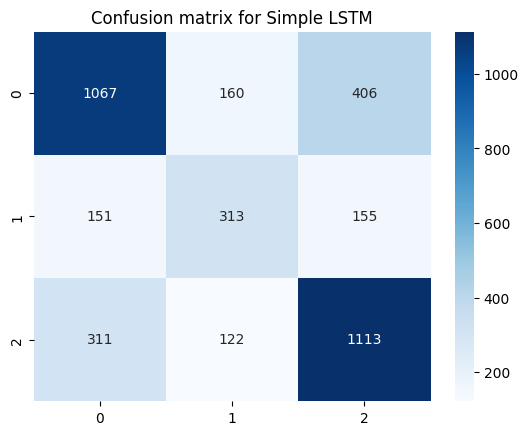

In [47]:
# Evaluate the model
simple_lstm.eval()
y_pred = simple_lstm(torch.tensor(X_test).float().unsqueeze(1))

# Calculate the accuracy
test_acc = (y_pred.argmax(1) == torch.tensor(y_test.values).long()).float().mean()
print("Test accuracy: ", test_acc)

# Save the model
torch.save(simple_lstm, '../out/textclass_simple_lstm.pth')

# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred.argmax(1).numpy())
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix for Simple LSTM')